In [1]:
#!/usr/bin/env python3
import logging
import os
import subprocess
import time
from scipy import signal
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
from scipy.interpolate import interp1d, CubicSpline as spline
from sympy import I


from neat.fields import  StellnaQS
from neat.tracing import ChargedParticle, ParticleOrbit
from neat.plotting import butter_lowpass_filter, butter_lowpass_filter2

Trace the orbit of a single particle in a
quasisymmetric stellarator using Near Axis and VMEC   

In [2]:
step_i=0.925
nfp=2
s_initials = np.round(np.arange(0.25,0.8,step_i), 2) # psi/psi_a for vmec
# s_initials = [0.1, 0.25,0.5, 0.75]

# Initial values for lambdas

lambdas=np.round(np.arange(0.98,0.991,0.51), 2) # = mu * B0 / energy

# Initial angular values

theta_initials=np.round(np.arange(1.26,2*np.pi,10*2*np.pi/10), 2)         # initial poloidal angle (vartheta=theta_Boozer - N phi_Boozer)
phi_initials=np.round(np.arange(0.31,2*np.pi/nfp,10*2*np.pi/nfp/10), 2)    # initial toroidal angle (cylindrical on axis)

# theta_initials=[0.25]#,1.1266087039264279,2.0149839496633657, 3.1415926535897931]
# phi_initials=[0.25]#,1.1266087039264279,2.0149839496633657, 3.1415926535897931]

# QA -> (theta, phi)= (0,0), (3.77,0)
# QH -> (theta, phi)= (0,0.94), (0.79,0.3), (1.26,0.93)

#Particle values
B0 = 5.3267         # Tesla, magnetic field on-axis (ARIES-CS)
energy = 3.52e6     # electron-volt
charge = 2          # times charge of proton
mass = 4            # times mass of proton
nsamples = 20000  # resolution in time
tfinal = 1e-3      # seconds
constant_b20 = False # use a constant B20 (mean value) or the real function

# Scaling values
Rmajor_ARIES = 7.7495*2
Rminor_ARIES = 1.7044
Aspect=np.round(Rmajor_ARIES/Rminor_ARIES,2)

# List of working stellarators
stellarator = ["precise QA", "2022 QH nfp4 well"]

# Initializing and scaling NA field
g_field_basis = StellnaQS.from_paper(stellarator[0], B0=B0, nphi=401)
g_field = StellnaQS(rc=g_field_basis.rc*Rmajor_ARIES, zs=g_field_basis.zs*Rmajor_ARIES, \
                    etabar=g_field_basis.etabar/Rmajor_ARIES, B2c=g_field_basis.B2c*(B0/Rmajor_ARIES/Rmajor_ARIES),\
                        B0=B0, nfp=g_field_basis.nfp, order='r3', nphi=401)

g_orbits = [
    ParticleOrbit(
        ChargedParticle(
            r_initial=Rminor_ARIES*np.sqrt(s_initial),
            theta_initial=theta_initial-(g_field.iota-g_field.iotaN)*phi_initial,
            phi_initial=phi_initial,
            energy=energy,
            Lambda=lambdas[i],
            charge=charge,
            mass=mass,
            vpp_sign=vpp_sign,
        ),
        g_field,
        nsamples=nsamples,
        tfinal=tfinal,
        constant_b20=constant_b20
    )
    for i in np.arange(lambdas.size)
    for s_initial in s_initials
    for theta_initial in theta_initials
    for phi_initial in phi_initials
    for vpp_sign in [-1]
]


In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams['lines.linewidth'] = 1
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font', size=24)
plt.rc('legend', fontsize=18)
plt.rc('lines', linewidth=3)

NEAT


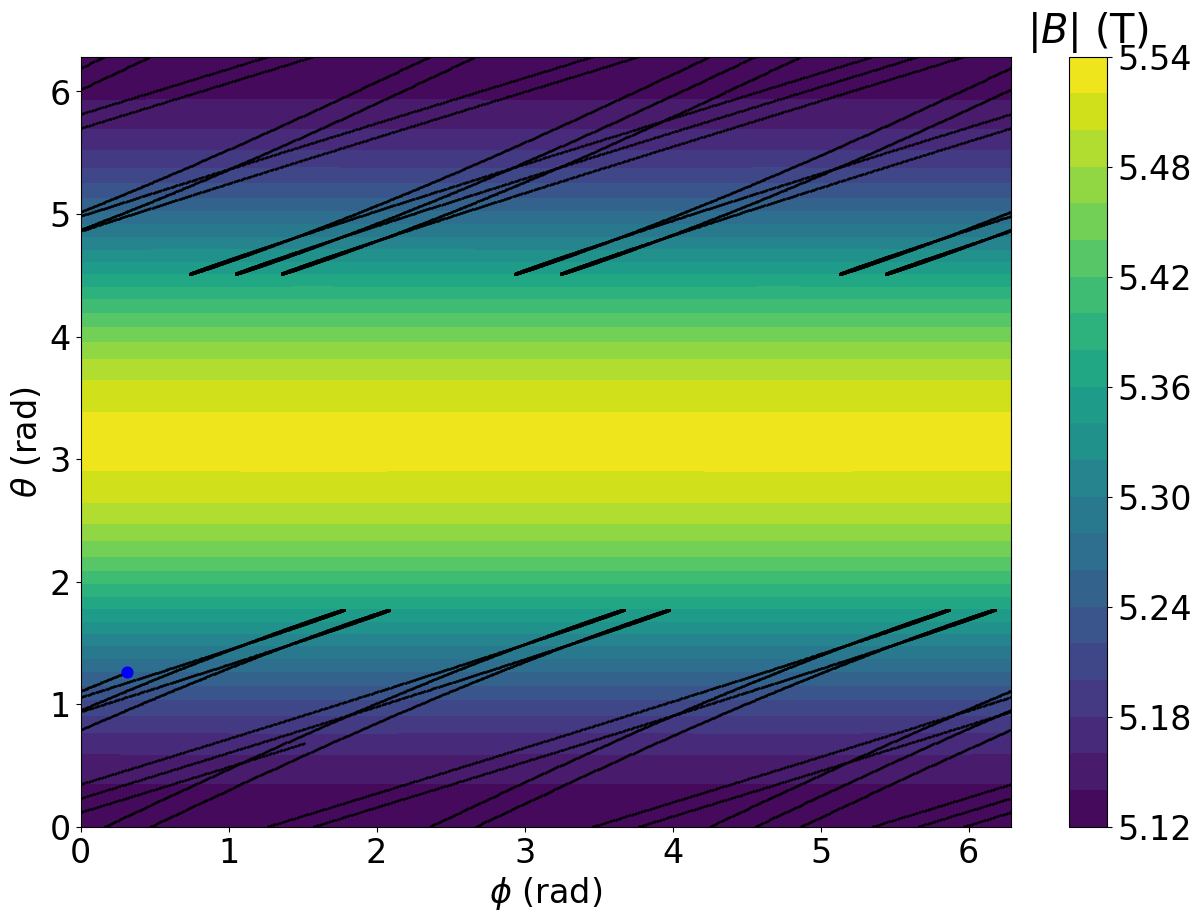

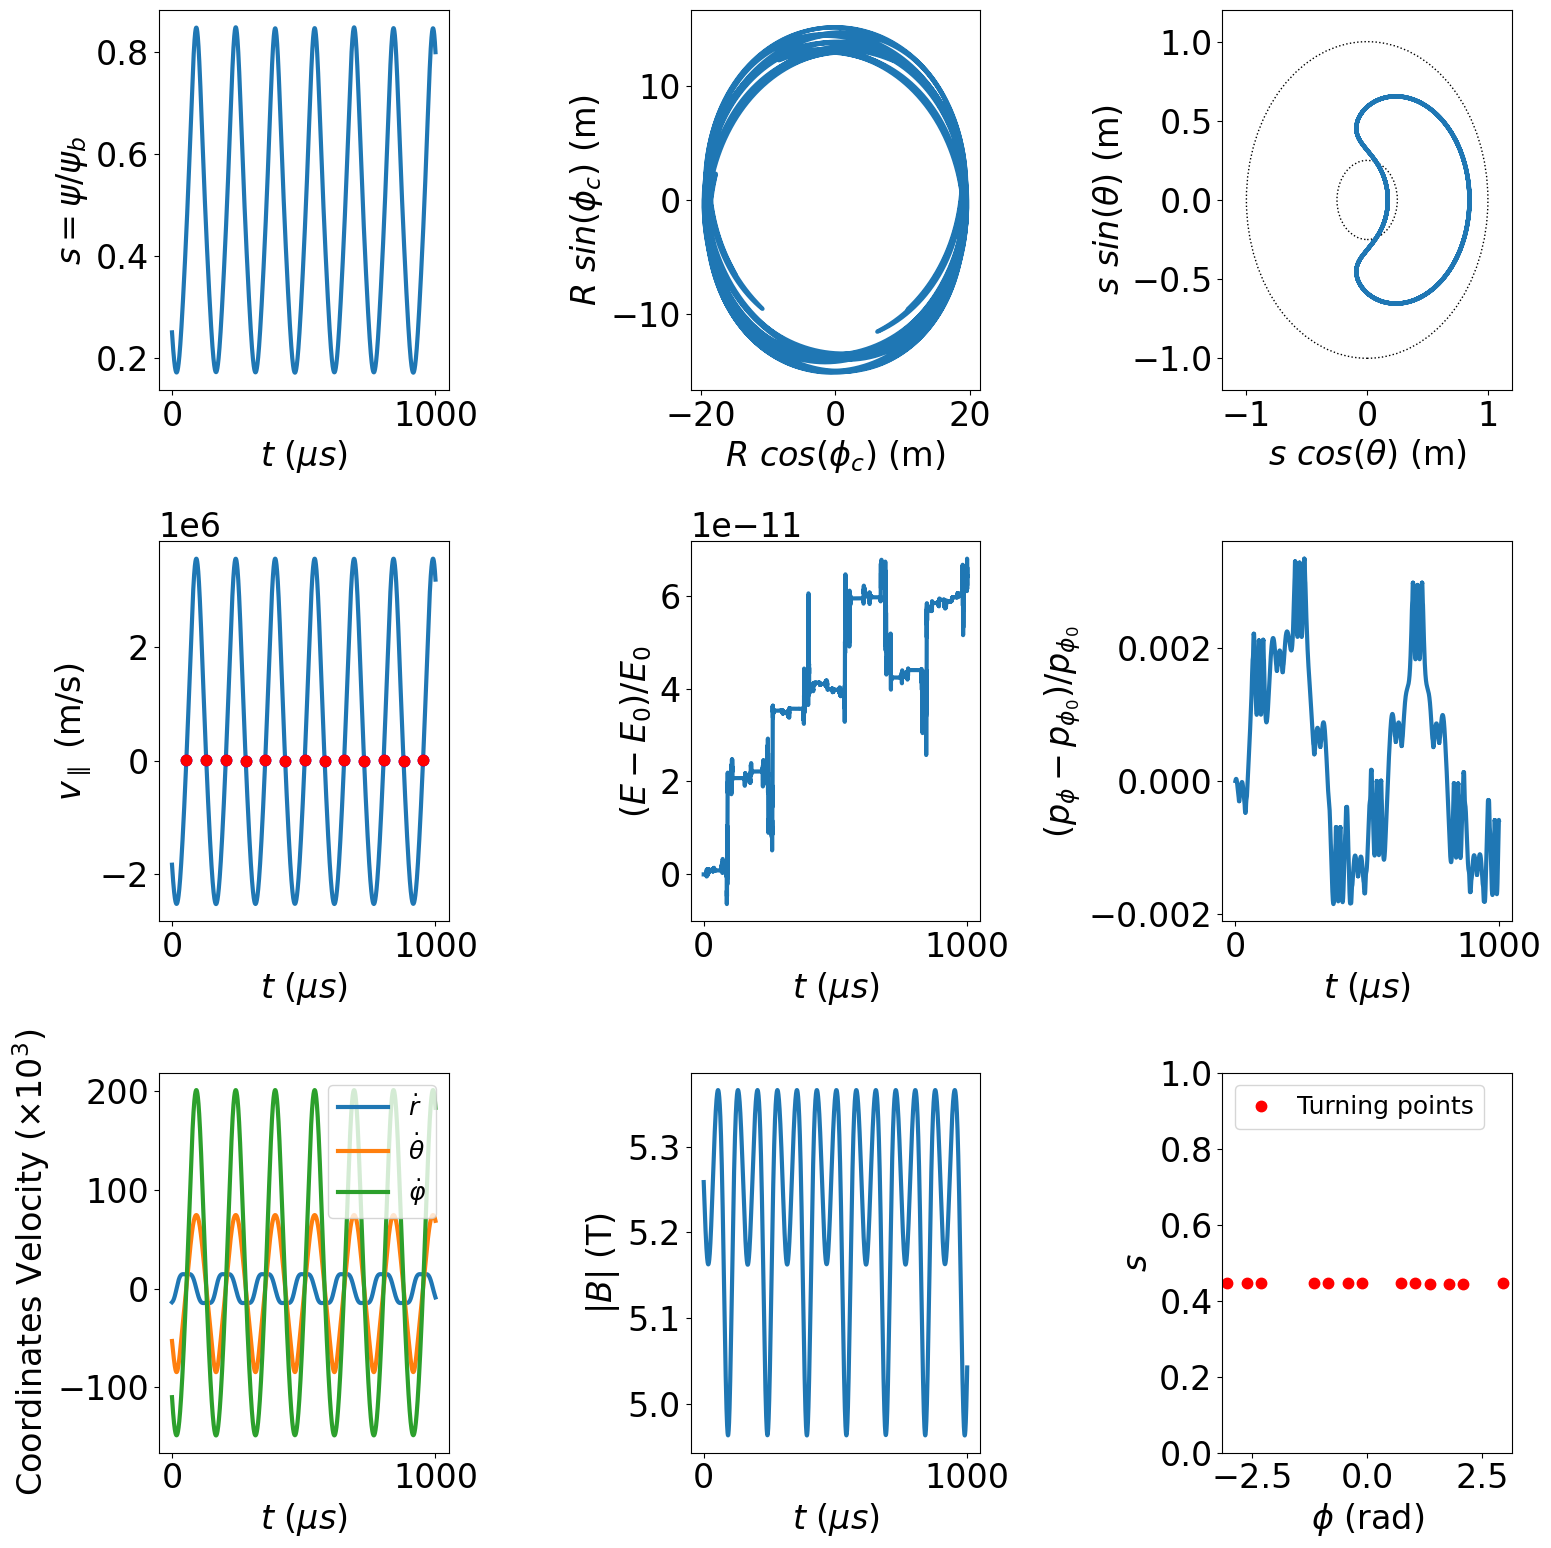

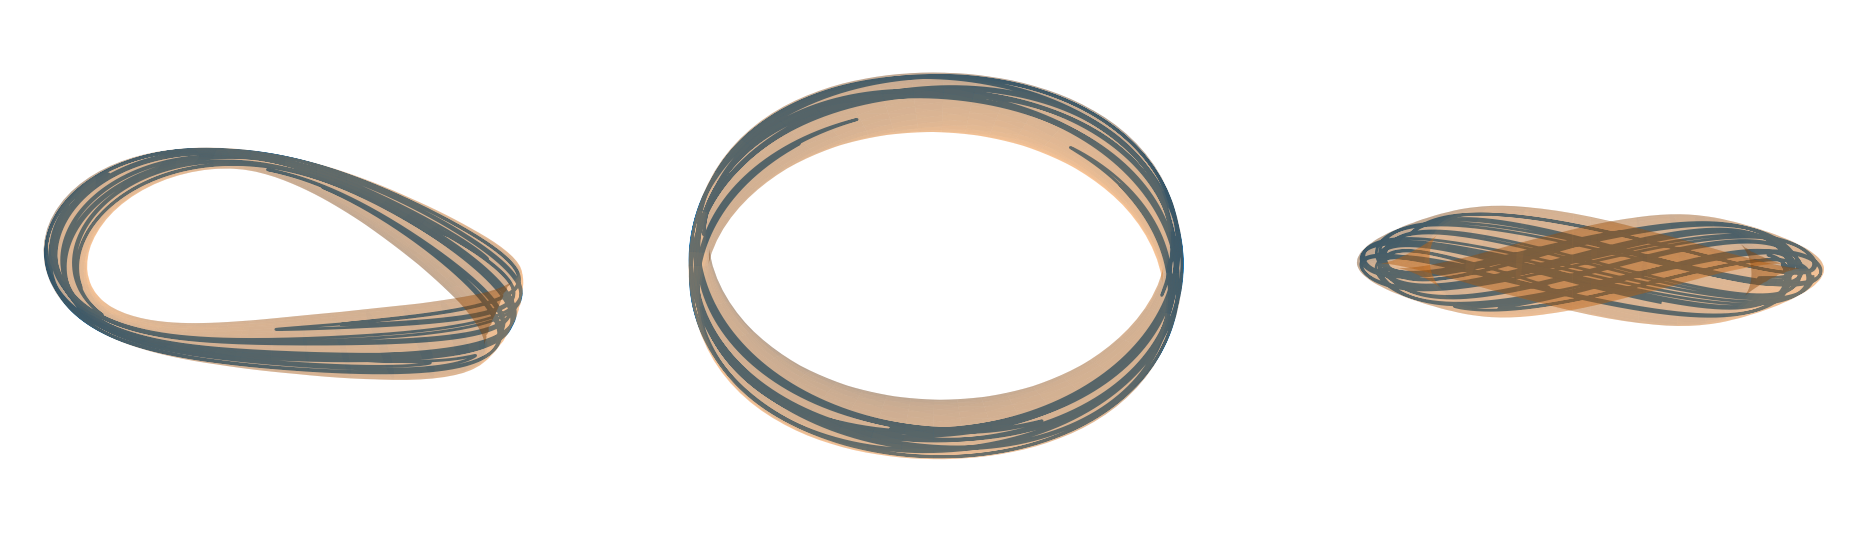

In [5]:

if not os.path.exists(stellarator[0] + '_QSC_A=' + str(Aspect)):
    os.mkdir(stellarator[0] + '_QSC_A=' + str(Aspect))
norms_r_pos=[]
norms_r_pos_filt=[]

for i in np.arange(0,len(g_orbits),1):  
    s_i=np.round(0.1 + step_i*i,2)
    if not os.path.exists(stellarator[0] + '_QSC_A=' + str(Aspect) + '/' + str(s_i)):
        os.mkdir(stellarator[0] + '_QSC_A=' + str(Aspect) + '/' + str(s_i))
    norm_r_pos = (g_orbits[i].r_pos/(Rminor_ARIES))**2
    peaks, _= signal.find_peaks(norm_r_pos,distance=(4/100)*g_orbits[i].time.size)
    valleys,_= signal.find_peaks(-norm_r_pos,distance=(4/100)*g_orbits[i].time.size)

    if peaks.size>valleys.size: peaks=peaks[:valleys.size]
    else: valleys=valleys[:peaks.size]

    fs = 1 / ( g_orbits[i].time[1] - g_orbits[i].time[0] )  # Sampling frequency
    cutoff = 1e4                     # Frequency cutoff value in Hz

    norm_r_pos_filt = butter_lowpass_filter(norm_r_pos, cutoff, fs)
    
    avg_time=(g_orbits[i].time[peaks]+g_orbits[i].time[valleys])*1e6/2
    # plt.plot(avg_time-avg_time[0]/2, norm_r_pos[peaks]-norm_r_pos[valleys],label='NA s_i='+str(np.round(0.1 + step_i*i,2)))


    print('NEAT')
    g_orbits[i].plot_orbit_contourB(savefig=stellarator[0] + '_QSC_A=' + str(Aspect) + '/' + str(s_i)+'/B_neat.png',show=False)
    g_orbits[i].plot(r_minor=Rminor_ARIES, savefig=stellarator[0] + '_QSC_A=' + str(Aspect) + '/' + str(s_i)+'/param_neat.png',show=True)
    plt.rc('lines', linewidth=2)
    g_orbits[i].plot_orbit_3d(r_surface=Rminor_ARIES, savefig=stellarator[0] + '_QSC_A=' + str(Aspect) + '/' + str(s_i)+'/smth',show=True)